**Table of contents**<a id='toc0_'></a>  

- [1.     Introduction ](#section-0)
    - [1.1   Setting up](#section-1)
	- [1.2   Data Preprocessing and Visualization](#section-1.1)

- [2.     Stationarity](#section-2)
	- [2.1   Why is Stationarity important?](#section-2.1)
    - [2.2   ACF and PACF plots](#section-2.2)
    - [2.3   Plotting Rolling Statistics](#section-2.3)
    - [2.4   Augmented Dickey-Fuller Test](#section-2.4)
    - [2.5   Making Time Series Stationary](#section-2.5)
- [3.     Time Series forecasting](#section-3)
	- [3.1   Time Series Forecasting techniques](#section-3.1)
    - [3.2   Introduction to ARIMA Models](#section-3.2)
    - [3.3   Autoregression (AR)](#section-3.3)
		- [3.3.1   Forecast quality scoring metrics](#section-3.3.1)
    - [3.4   Moving Average (MA)](#section-3.4)
    - [3.5   Autoregressive Moving Average (ARMA)](#section-3.5)
    - [3.6   Autoregressive Integrated Moving Average (ARIMA)](#section-3.6)
    - [3.7   Seasonal Autoregressive Integrated Moving-Average (SARIMA)](#section-3.7)
    - [3.8   SARIMAX](#section-3.8)
- [4.     Improving Time Series Forecast models](#section-4)
- [5.     Further reading](#section-5)



<a name="section-0"></a>
# 1. Introduction

<a name="section-1"></a>
## 1.1 Setting up

### Importing Libraries for time series forecasting

In [26]:
!pip install pmdarima

In [27]:
# alternatively, install the libraries using the following
#!pip install -U pmdarima

In [28]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

### Importing data
The dataset represents the monthly total number of visits to the UK by overseas residents (in thousands) from January 1980 to October 2017. 
<a id='toc1_2_2_1_'></a>

Source: [Office for National Statistics]
(https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/timeseries/gmaa/ott)  

In [29]:
# Learner version: load data into datdframe
df = pd.read_csv("Data/international-airline-passengers.csv", header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value.astype(int, copy=False);

In [30]:
df.columns = ['year','passengers']

In [31]:
df.head(3)

,year,passengers
0,1949-07-01,148
1,1949-08-01,148
2,1949-09-01,136


In [32]:
df.describe()

,year,passengers
count,138,138.000000
mean,1955-03-17 12:20:52.173913024,287.072464
min,1949-07-01 00:00:00,104.000000
25%,1952-05-08 18:00:00,188.750000
50%,1955-03-16 12:00:00,270.500000
75%,1958-01-24 06:00:00,362.000000
max,1960-12-01 00:00:00,622.000000
std,NaN,117.940826


In [33]:
# Learner version: print start and end of time period
print('Time period start: {}\nTime period end: {}'.format(df.year.min(),df.year.max()))

Time period start: 1949-07-01 00:00:00
Time period end: 1960-12-01 00:00:00


In [34]:
df.shape

(138, 2)

<a name="section-1.1"></a>
## 1.2 Data Preprocessing and Visualization

__Converting to datetime format:__

In [35]:
# Learner version: convert column 'year' into datetime format
df['year'] = pd.to_datetime(df['year'], format='%Y-%m')

__Setting index as the datetime column for easier manipulations:__

In [36]:
y = df.set_index('year')

In [37]:
y.index

DatetimeIndex(['1949-07-01', '1949-08-01', '1949-09-01', '1949-10-01', '1949-11-01', '1949-12-01', '1950-01-01', '1950-02-01', '1950-03-01', '1950-04-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01', '1960-11-01', '1960-12-01'], dtype='datetime64[ns]', name='year', length=138, freq=None)

In [38]:
y.isnull().sum()

passengers    0
dtype: int64

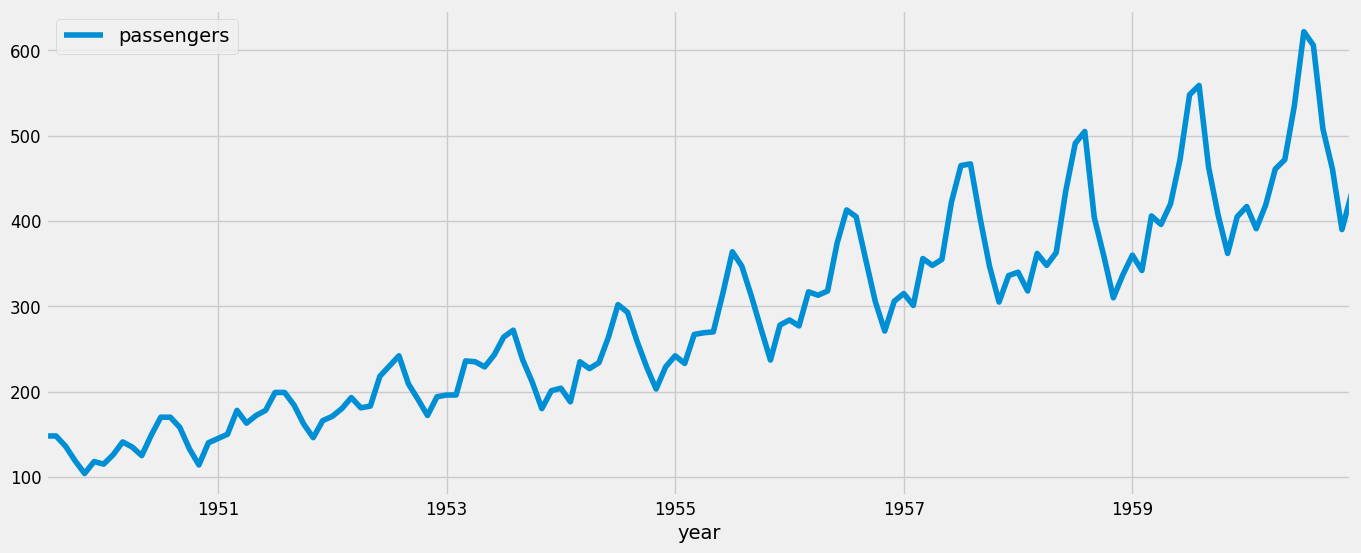

In [39]:
y.plot(figsize=(15, 6))
plt.show()

__Reviewing plots of the density of observations can provide further insight into the structure of the data:__
- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

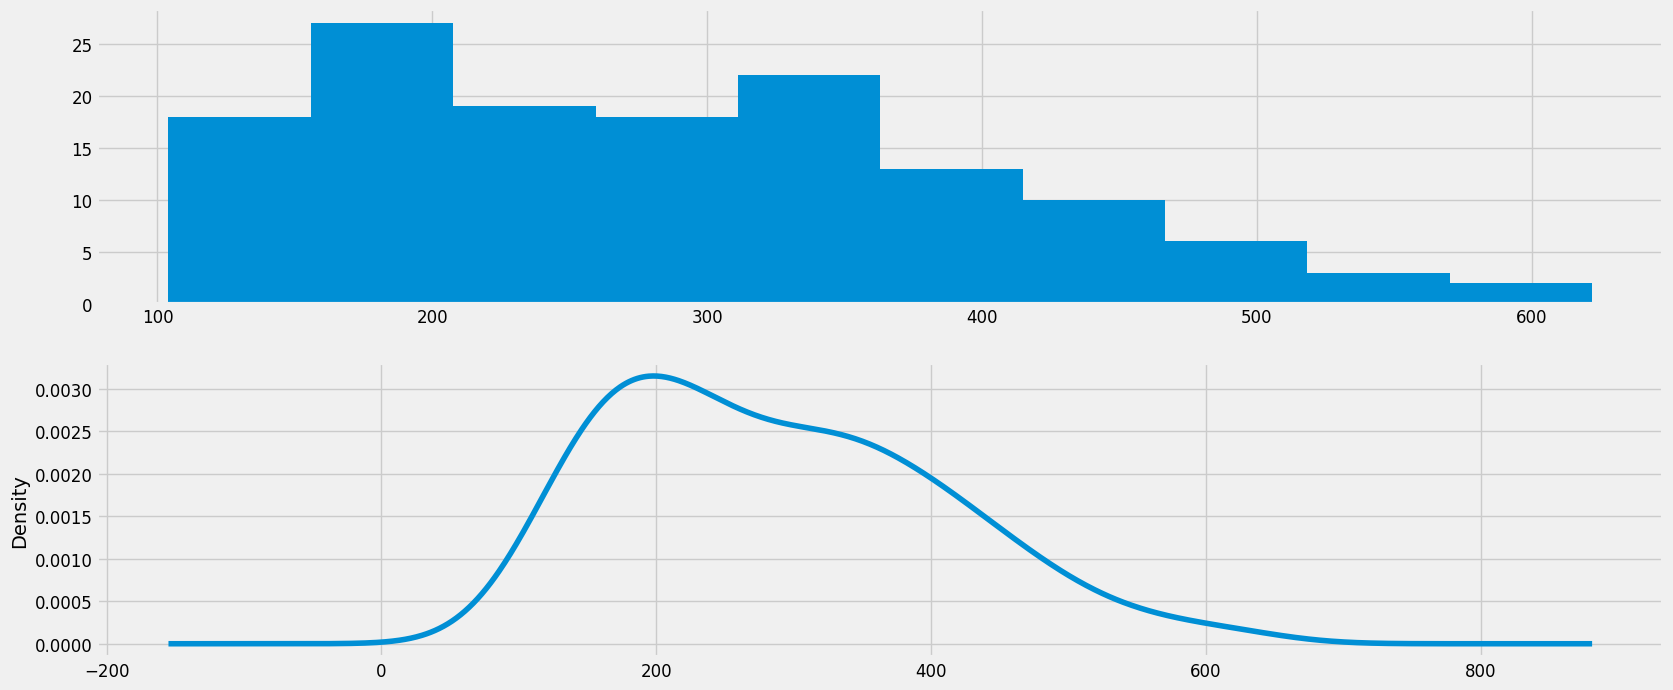

In [40]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.passengers.hist()
pyplot.subplot(212)
y.passengers.plot(kind='kde')
pyplot.show()

__Box and Whisker Plots:__
- Median values across years confirms an upwards trend
- Steady increase in the spread, or middle 50% of the data (boxes) over time
- A model considering seasonality might work well

<Axes: xlabel='year', ylabel='passengers'>

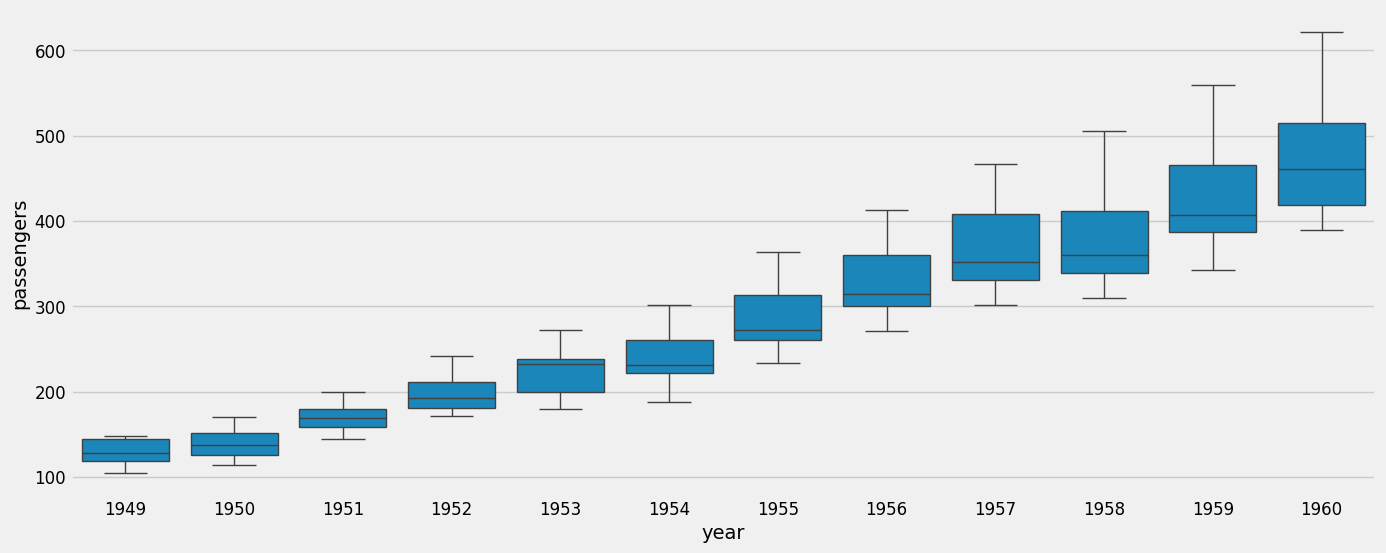

In [41]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(x=y.passengers.index.year, y=y.passengers, ax=ax)

__Decomposing using statsmodel:__
- We can use statsmodels to perform a decomposition of this time series. 
- The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. 
- With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

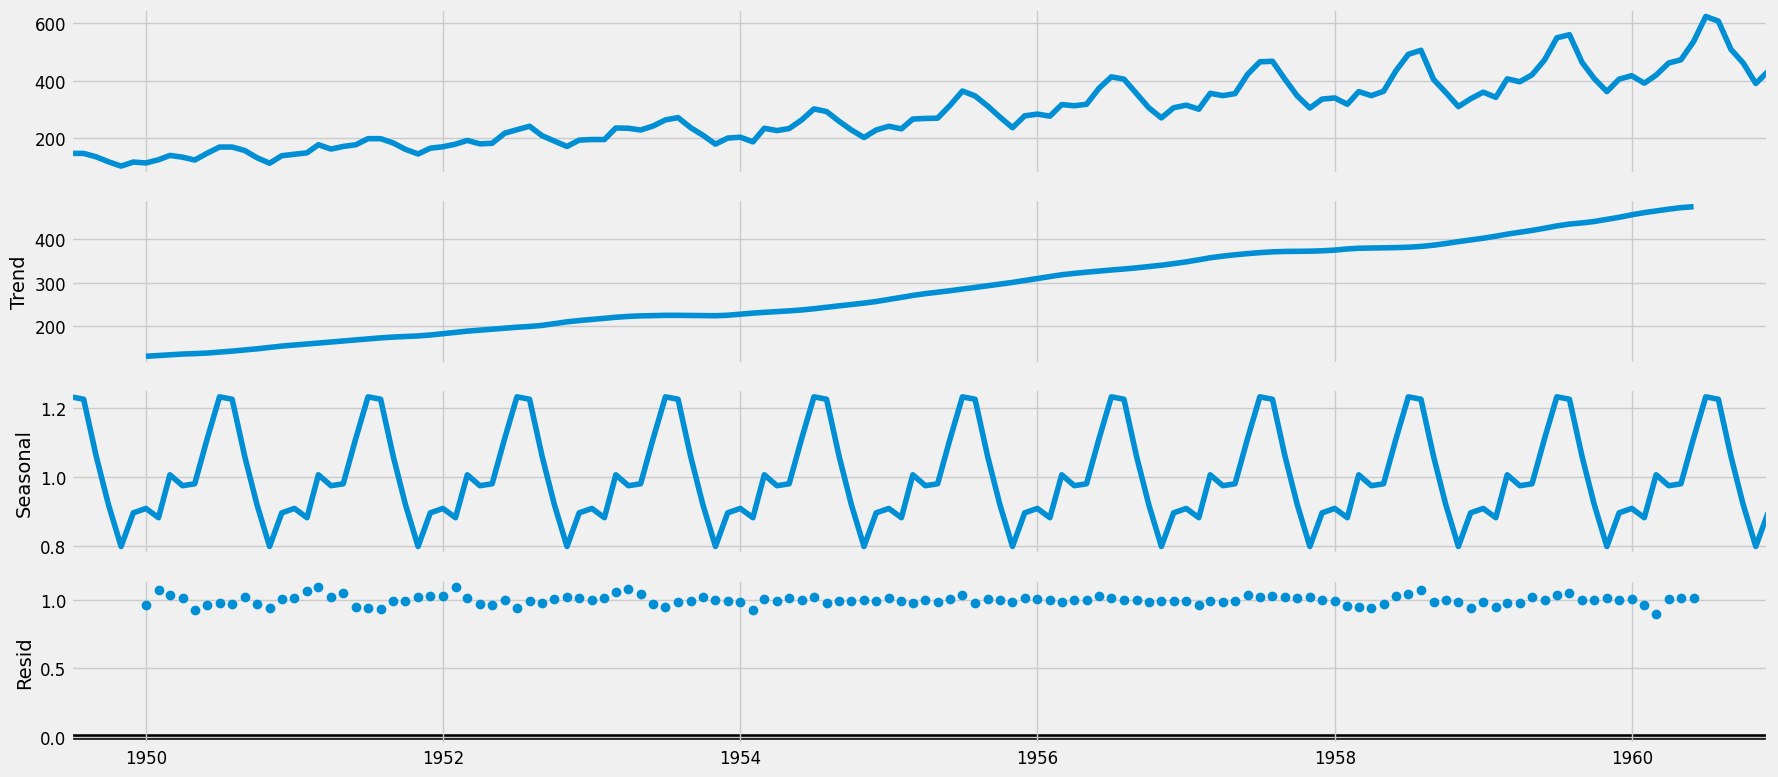

In [42]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()

<a name="section-2"></a>
# 2. Stationarity
- A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
- Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 
- Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

<a name="section-2.1"></a>
## 2.1 Why is Stationarity important?

To understand the importance of stationarity in time series, consider a parallel drawn to a typical statistical experiment involving a series of random samples taken from a sample space.
Consider multiple identical experiments i= 1, 2,...,n. where the samples are chosen randomly from a sample space in order to learn properties of the random variable X.

By law of large numbers, mean of Xis taken over n experiments converges to E(X).

In case of time series setting, the fundamental difference is that the multiple observations are observed over time t.
The mean over experiments may not converge to E(X) if means are not constant over time.

Stationarity is important in order to apply the laws of experiments involving multiple draws from a sample space to time series experiments


To sum up, a model describing the data will vary in accuracy at different time points. As such, stationarity is required for sample statistics such as means, variances, and correlations to accurately describe the data at all time points of interest.


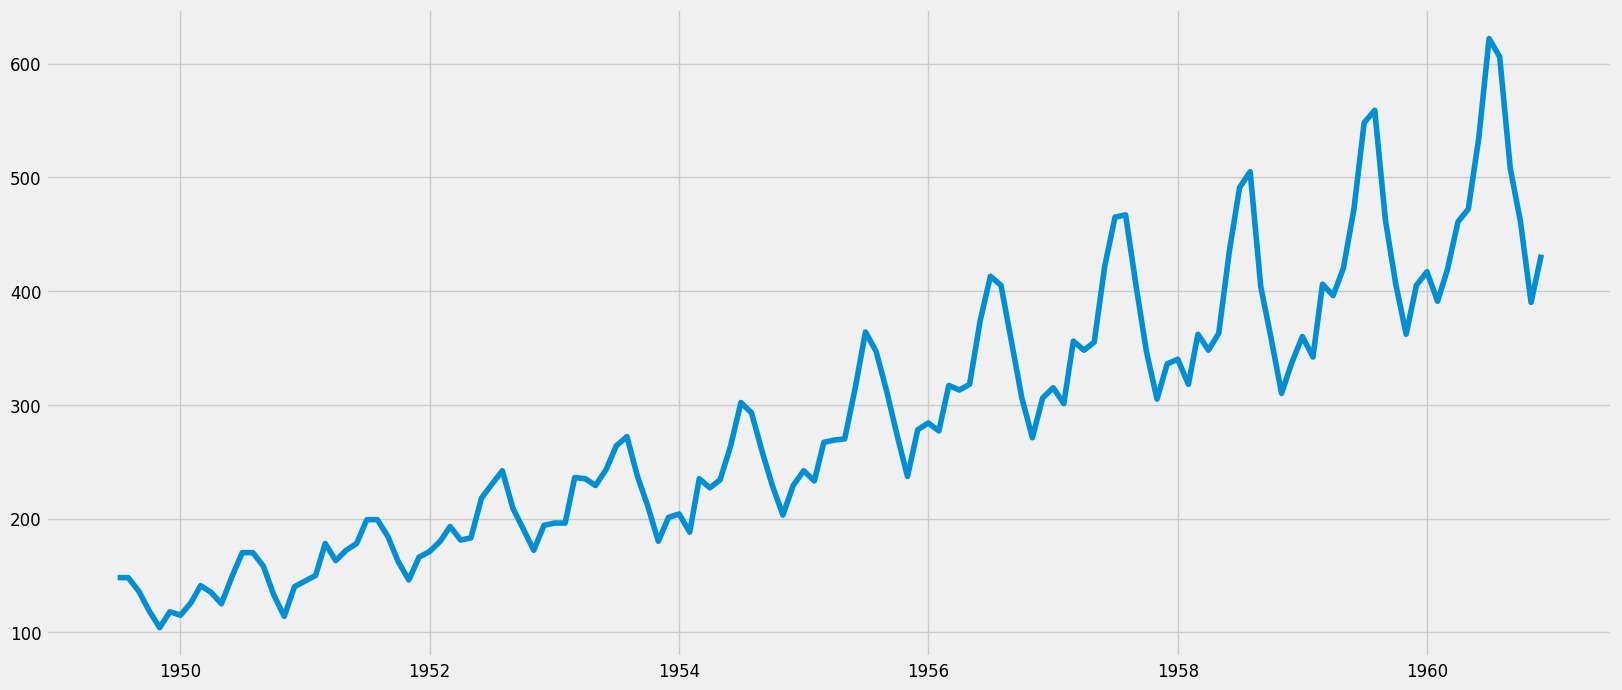

In [43]:
# Learner version: plot a line graph of y
plt.plot(y)

__We can check stationarity using the following:__

- __ACF and PACF plots__: If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- __Plotting Rolling Statistics__: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
- __Augmented Dickey-Fuller Test:__ This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

<a name="section-2.2"></a>
## 2.2 ACF and PACF plots

- Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots
- If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- This data is non-stationary as a high number of previous observations are correlated with future values.
- Confidence intervals are drawn as a cone. 
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

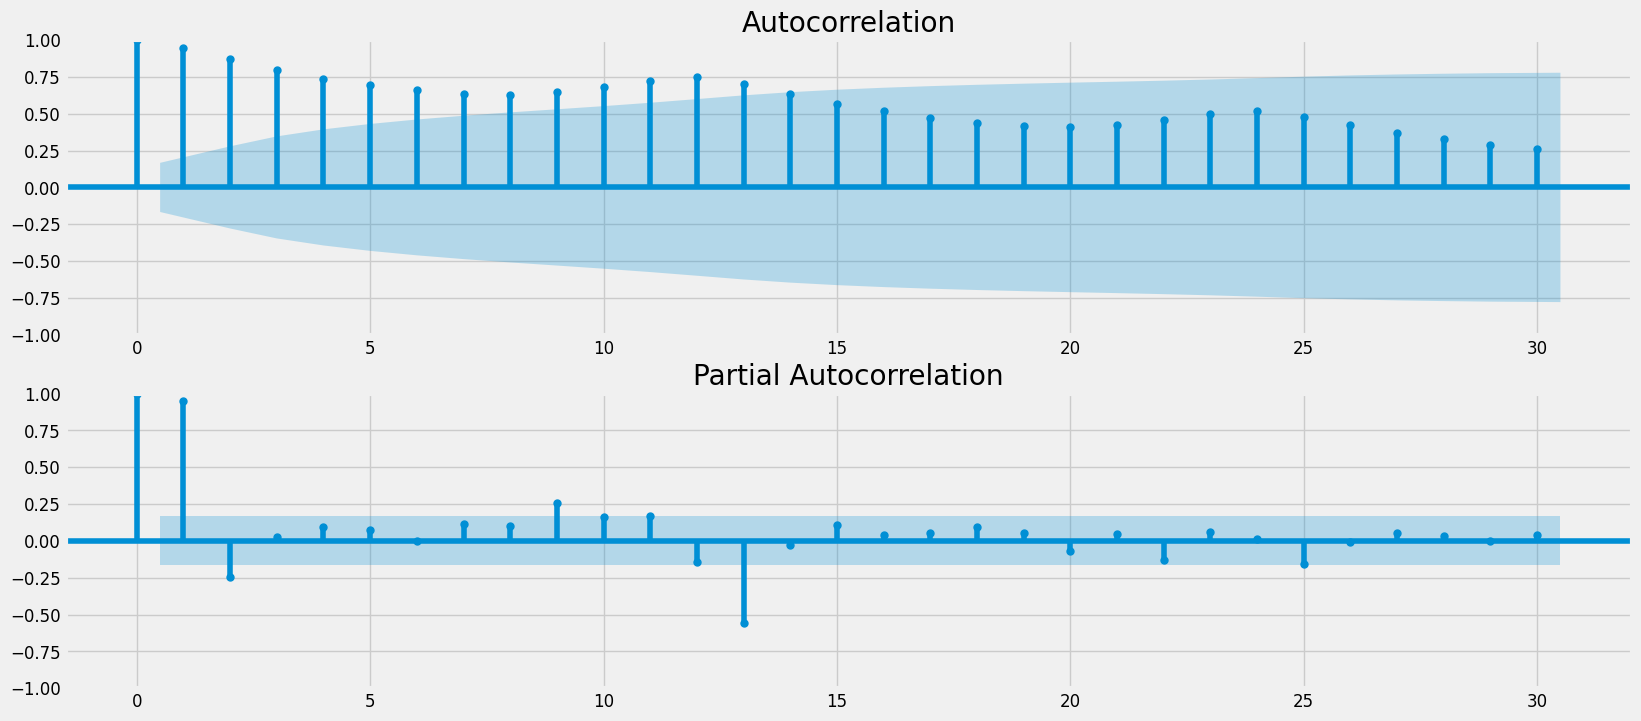

In [44]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y.passengers, ax=pyplot.gca(), lags = 30)
pyplot.show()

<a name="section-2.3"></a>
## 2.3 Plotting Rolling Statistics
- We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
- The time series is hence not stationary

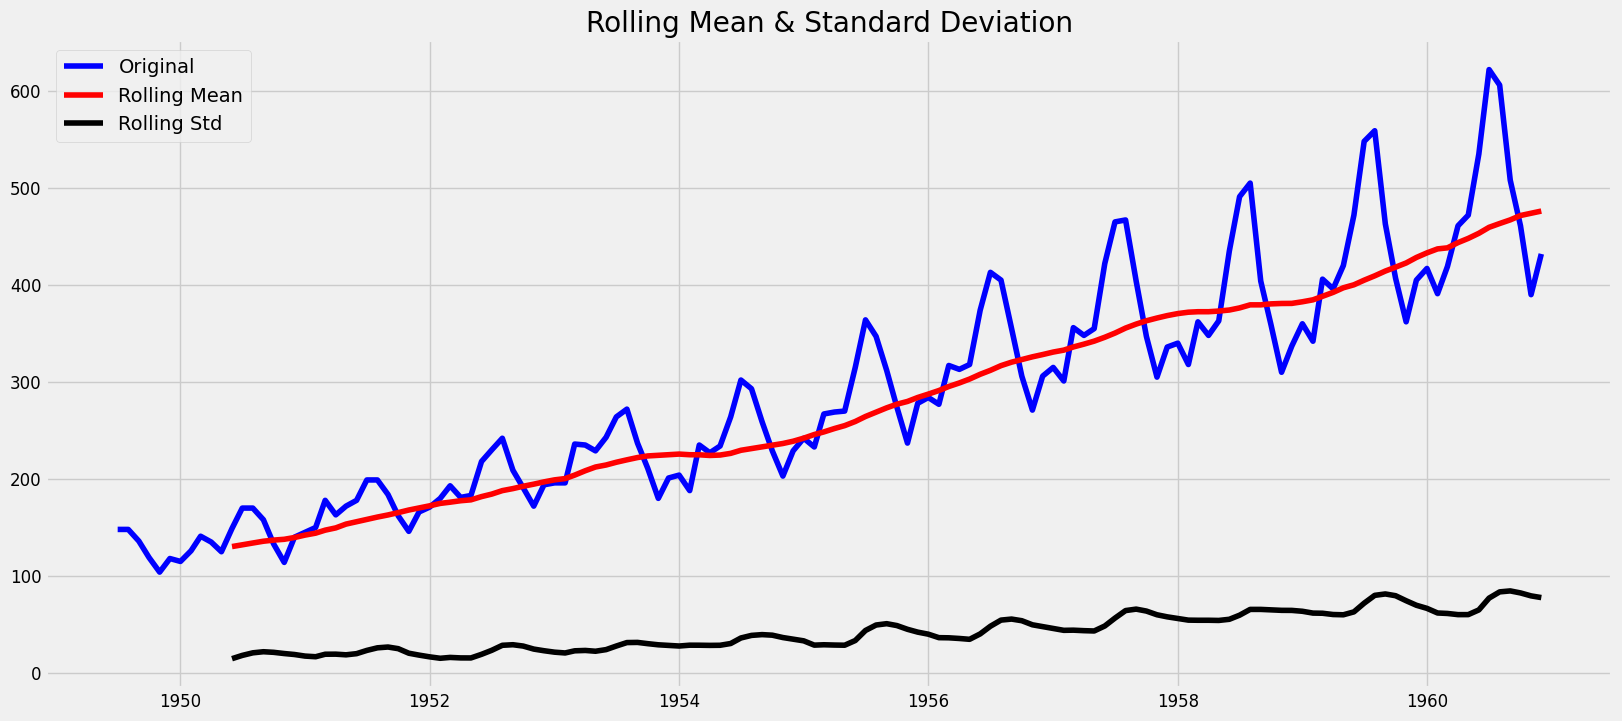

In [45]:
#Determing rolling statistics
rolmean = y.rolling(12).mean()
rolstd = y.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)


<a name="section-2.4"></a>
## 2.4 Augmented Dickey-Fuller Test
- The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1)  will provide no relevant information in predicting the change in y(t).
- Null hypothesis: The time series is not stationary
- Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [46]:
# Perform Dickey-Fuller test:
print('Results of Dickey-Fuller Test:')

dftest = adfuller(y.passengers, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                   0.740325
p-value                          0.990609
#Lags Used                      13.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


In [47]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

<a name="section-2.5"></a>
## 2.5 Making Time Series Stationary
There are 2 major reasons behind non-stationaruty of a TS:

1. __Trend__ – varying mean over time. For e.g., in this case we saw that on average, the number of passengers was growing over time.
2. __Seasonality__ – variations at specific time-frames. For e.g. people might have a tendency to buy cars in a particular month because of pay increment or festivals.

<a name="section-2.6"></a>
## 2.6 Transformations
- We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

#### Log Scale Transformation

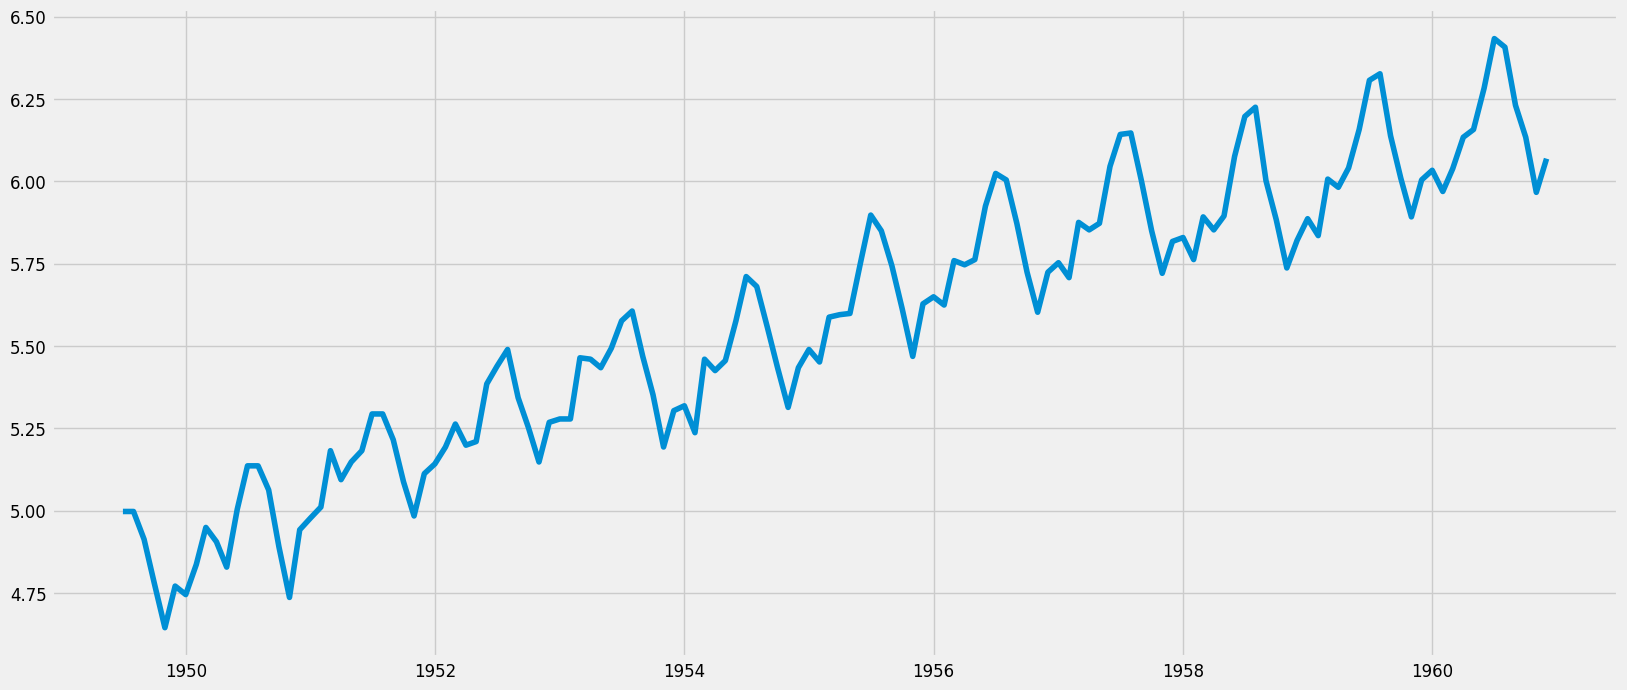

In [48]:
ts_log = np.log(y)
plt.plot(ts_log)


#### Other possible transformations:
- Exponential tranformation
- Box Cox transformation
- Square root transformation

### Techniques to remove Trend - Smoothing
- Smoothing is taking rolling averages over windows of time

#### Moving Average
- We take average of ‘k’ consecutive values depending on the frequency of time series. 
- Here we can take the average over the past 1 year, i.e. last 12 values. 
- A drawback in this particular approach is that the time-period has to be strictly defined. 

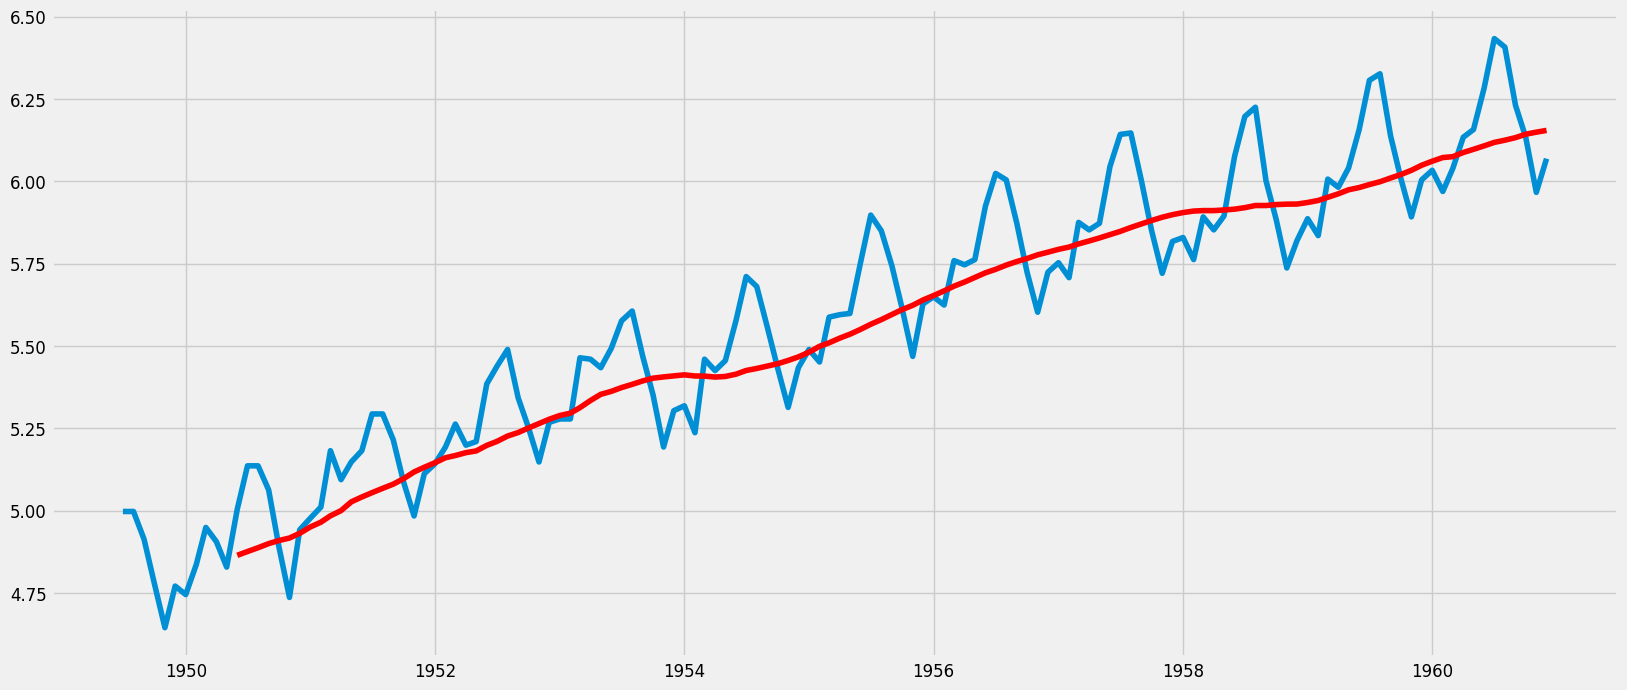

In [49]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [50]:
ts_log_moving_avg_diff = ts_log.passengers - moving_avg.passengers
ts_log_moving_avg_diff.head(12)

year
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01         NaN
1950-01-01         NaN
1950-02-01         NaN
1950-03-01         NaN
1950-04-01         NaN
1950-05-01         NaN
1950-06-01    0.139881
Name: passengers, dtype: float64

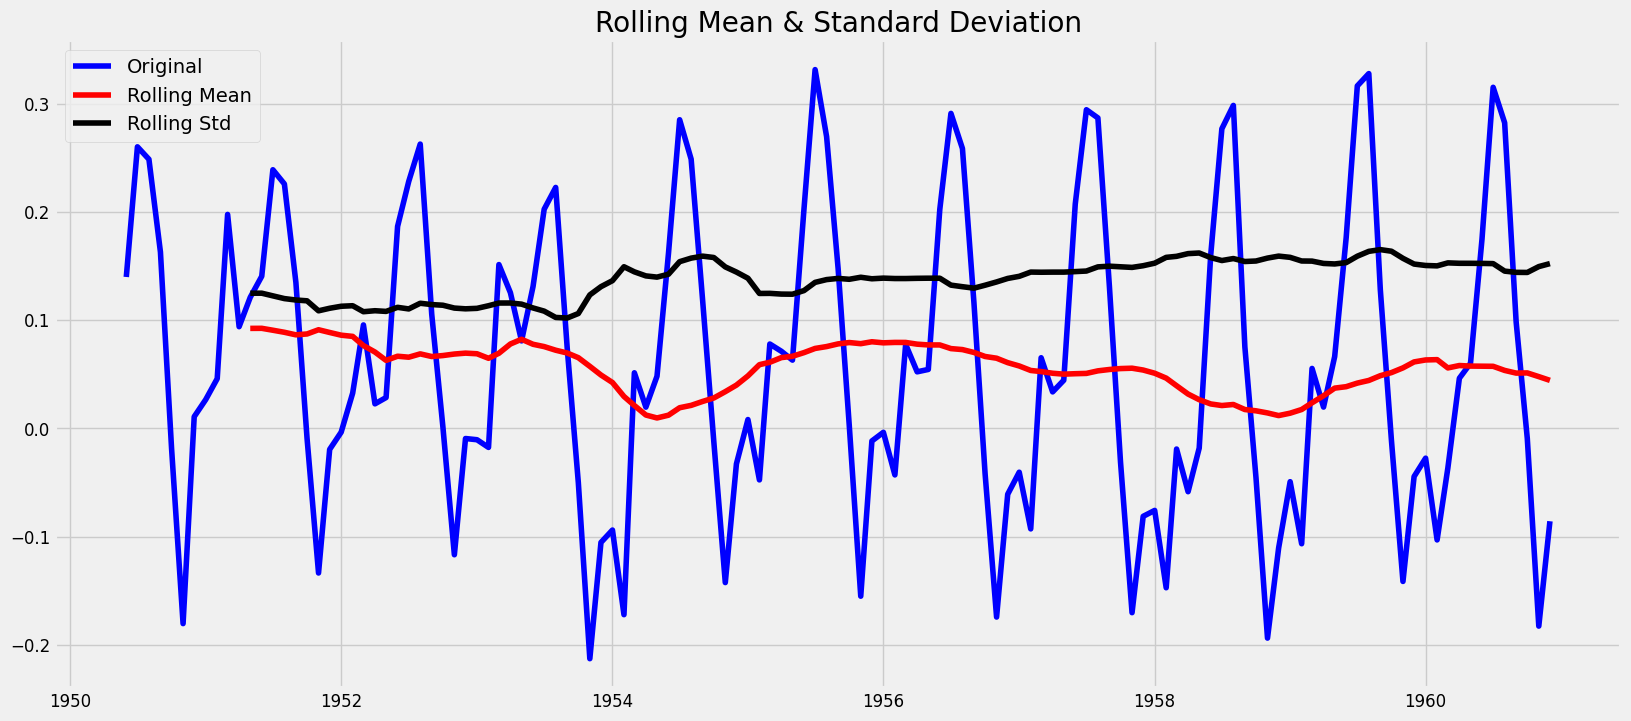

Results of Dickey-Fuller Test:
Test Statistic                  -2.930353
p-value                          0.041931
#Lags Used                      13.000000
Number of Observations Used    113.000000
Critical Value (1%)             -3.489590
Critical Value (5%)             -2.887477
Critical Value (10%)            -2.580604
dtype: float64


In [51]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

#### Exponentially weighted moving average:
- To overcome the problem of choosing a defined window in moving average, we can use exponential weighted moving average
- We take a ‘weighted moving average’ where more recent values are given a higher weight. 
- There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. 

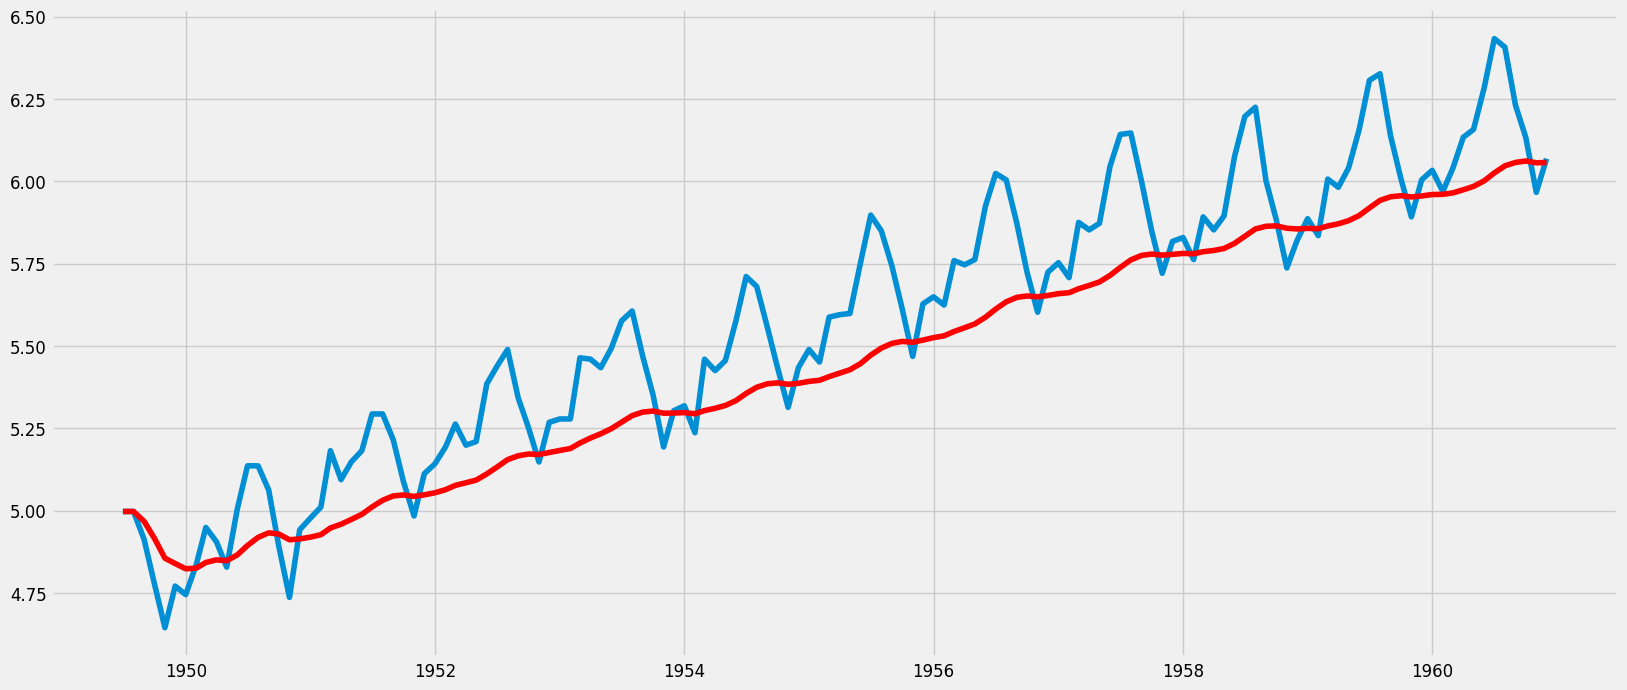

In [52]:
expweighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expweighted_avg, color='red')

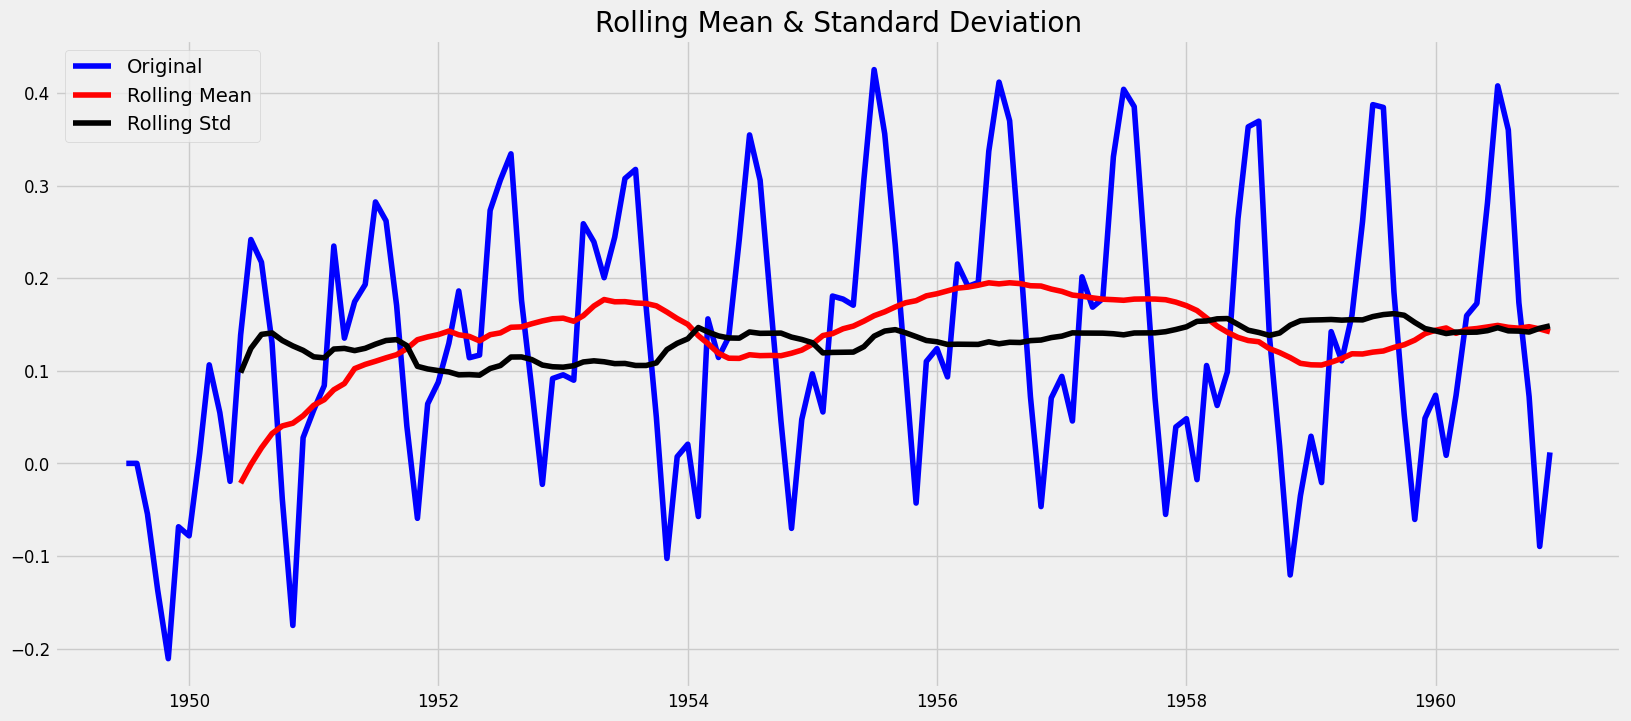

Results of Dickey-Fuller Test:
Test Statistic                  -2.376348
p-value                          0.148524
#Lags Used                      13.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


In [53]:
ts_log_ewma_diff = ts_log.passengers - expweighted_avg.passengers
test_stationarity(ts_log_ewma_diff)

### Further Techniques to remove Seasonality and Trend
- The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. 

#### Differencing
- In this technique, we take the difference of the observation at a particular instant with that at the previous instant. 
- First order differencing in Pandas

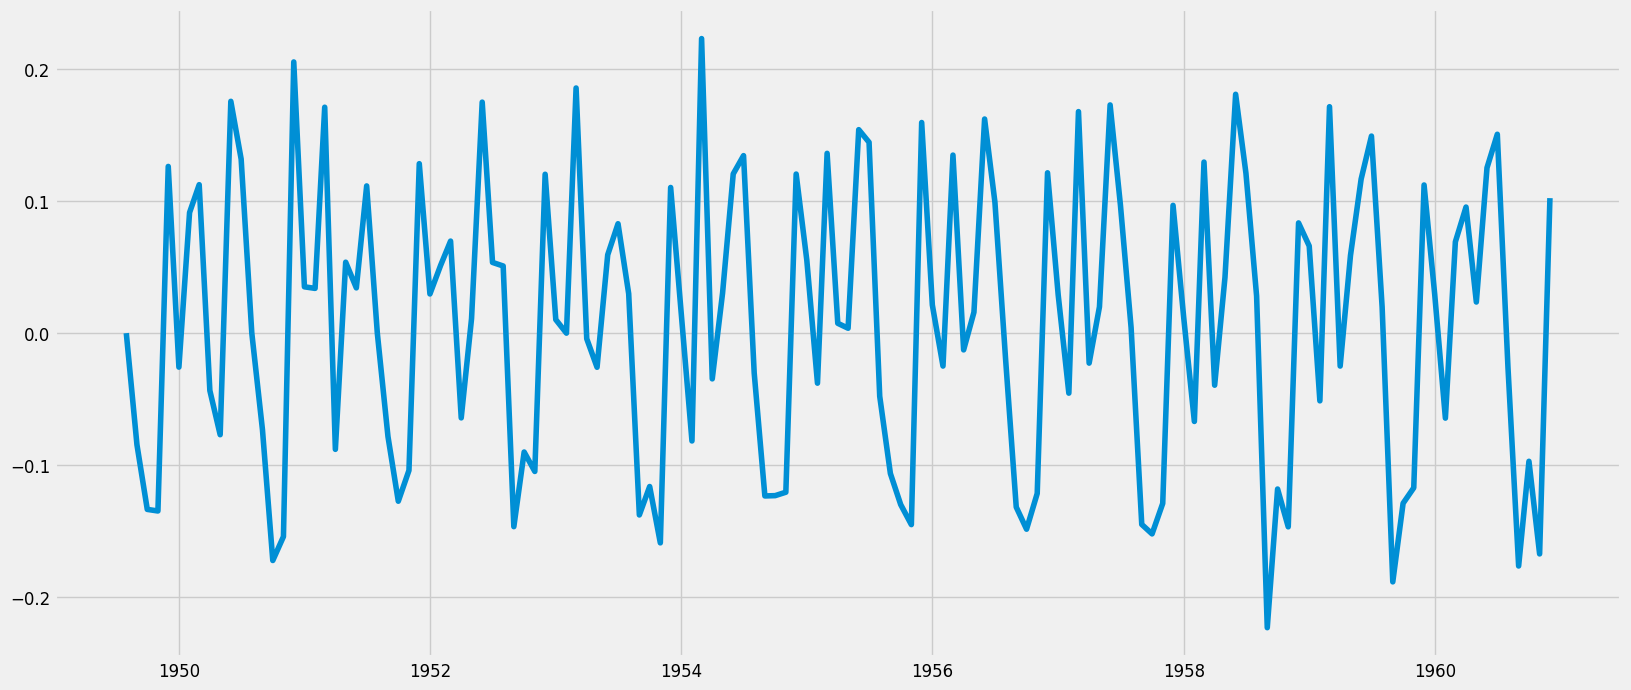

In [54]:
ts_log_diff = ts_log.passengers - ts_log.passengers.shift()
plt.plot(ts_log_diff)

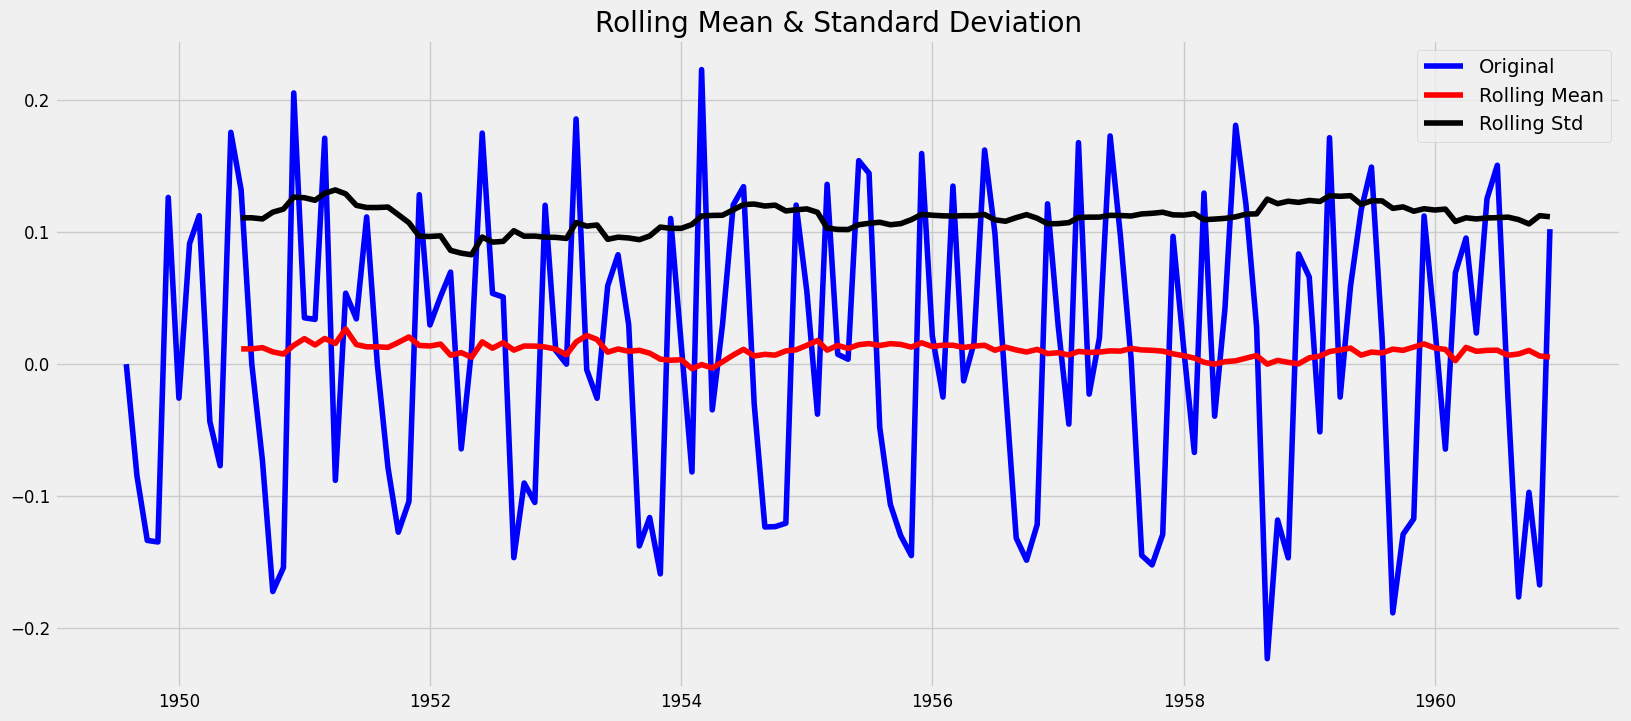

Results of Dickey-Fuller Test:
Test Statistic                  -2.836694
p-value                          0.053220
#Lags Used                      12.000000
Number of Observations Used    124.000000
Critical Value (1%)             -3.484220
Critical Value (5%)             -2.885145
Critical Value (10%)            -2.579359
dtype: float64


In [55]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

#### Decomposition
- In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

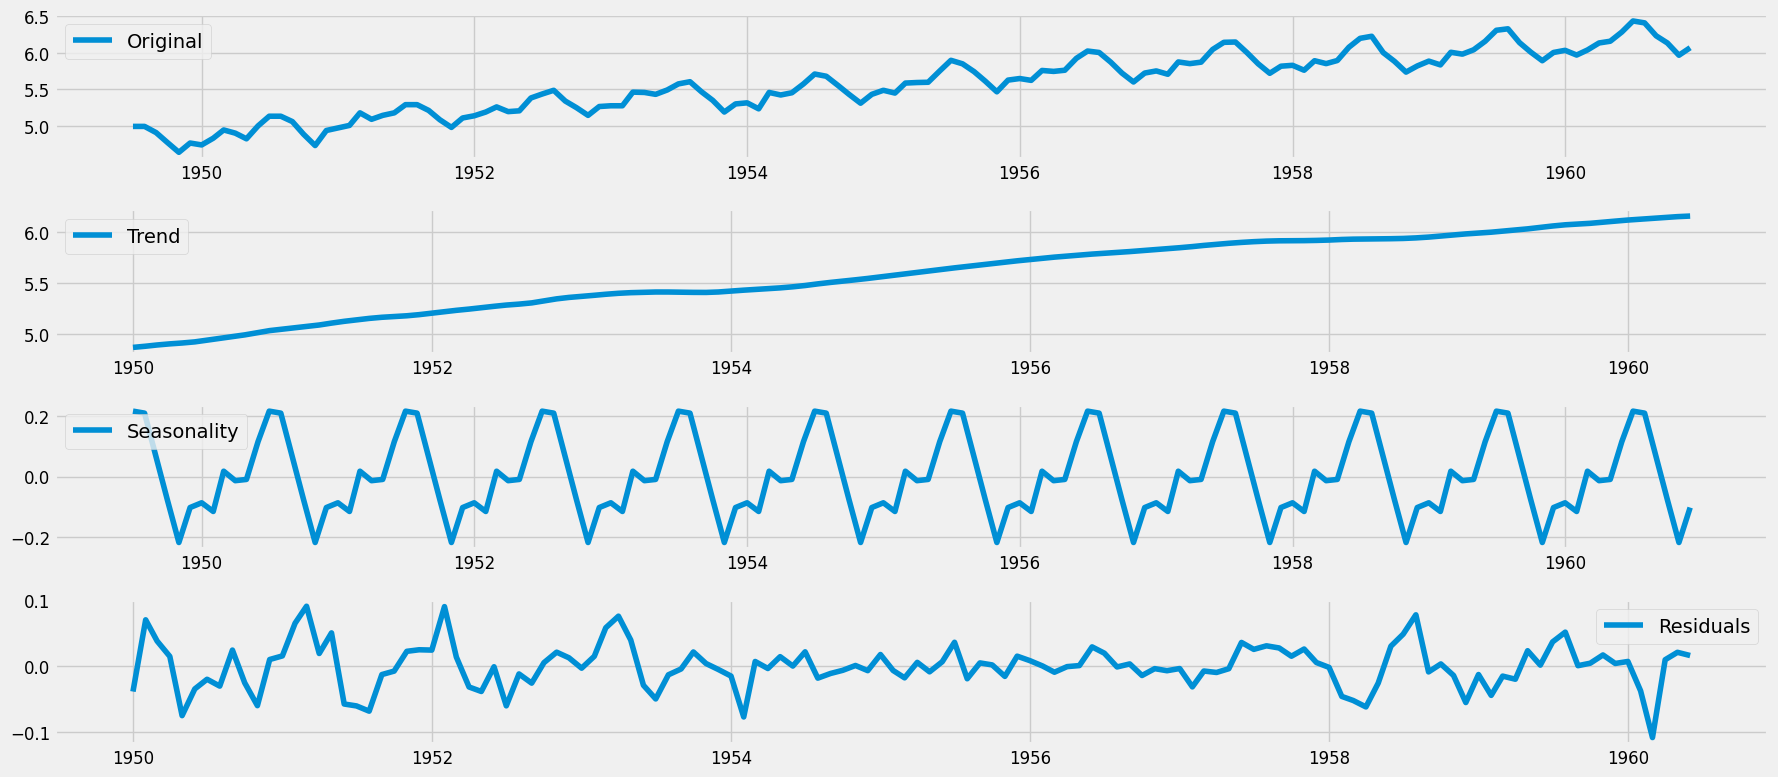

In [56]:
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

___
<a name="section-3"></a>
# 3. Time Series forecasting


<a name="section-3.1"></a>
## 3.1 Time Series Forecasting techniques

<br> 
 
 <centre> <img src="./images/Forecasting_Techniques_2.png" height="1500" width="1000"> </centre>

<a name="section-3.2"></a>
## 3.2 Introduction to ARIMA Models

An ARIMA (AutoRegressive Integrated Moving Average) model is a class of statistical models for analyzing and forecasting time series data.

This acronym is descriptive, capturing the key aspects of the model itself. Briefly, they are:

- __AR__: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- __I__: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- __MA__: Moving Average. A simple moving average method uses arithmetic mean of last n observations contained in the time series to predict the next observation. This method of smoothing is based on the assumption that only a finite number of previous periods are significant in determining the forecast

The following chart explains different kinds of ARIMA based models-

<centre> <img src="./images/ARIMA_Models.png" height="1500" width="1000"> </centre>

**A key requirement for ARIMA models is stationarity of time series**

<a name="section-3.3"></a>
## 3.3 Autoregression (AR)
- The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.
- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [57]:
# fit model
model = AutoReg(ts_log_diff, lags=4)
model_fit = model.fit()

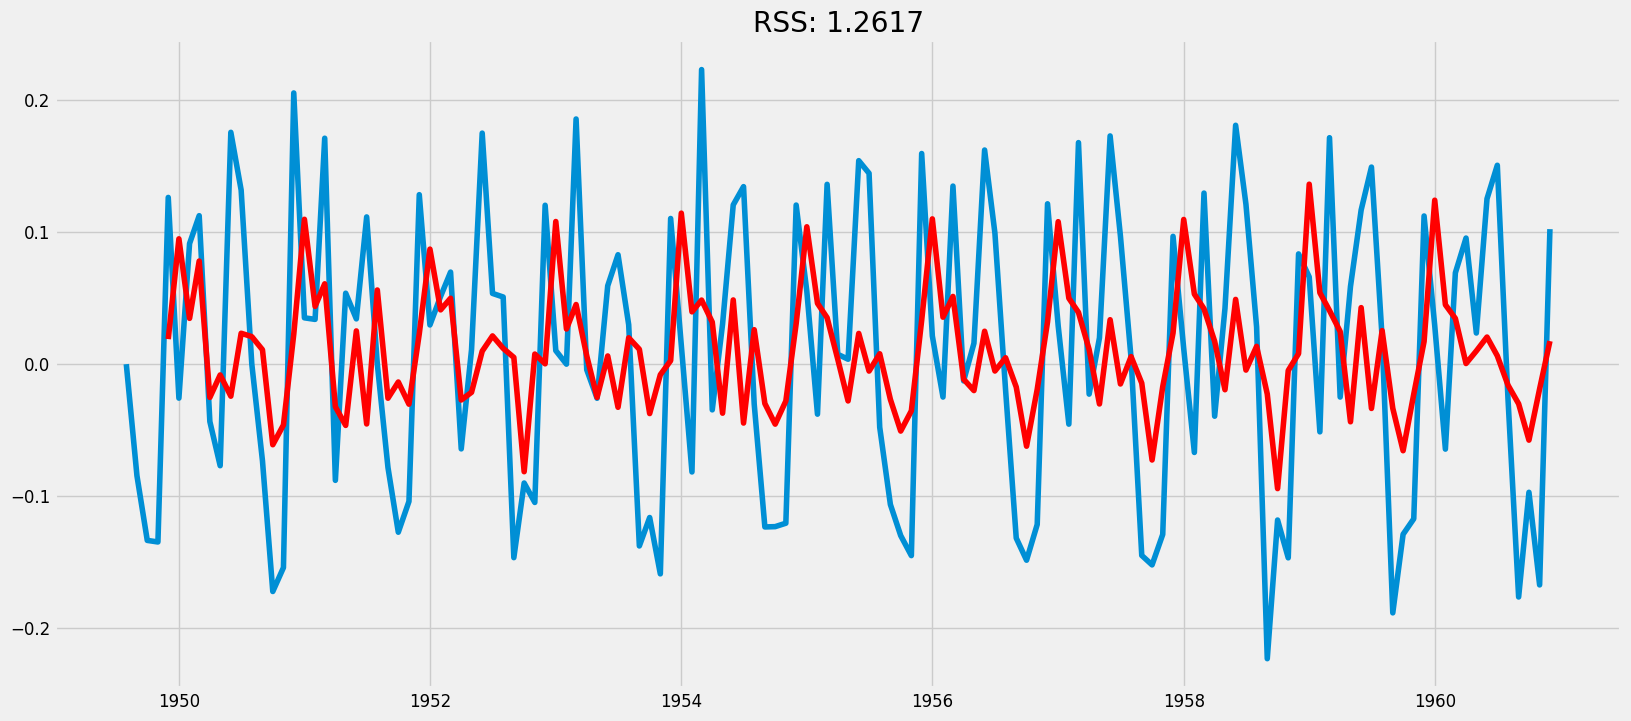

In [58]:
plt.plot(ts_log_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

### Reversing the transformations

__Fitted or predicted values:__

In [59]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

year
1949-12-01    0.018965
1950-01-01    0.094950
1950-02-01    0.034667
1950-03-01    0.078116
1950-04-01   -0.025221
dtype: float64


__Cumulative Sum to reverse differencing:__

In [60]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

year
1949-12-01    0.018965
1950-01-01    0.113914
1950-02-01    0.148582
1950-03-01    0.226698
1950-04-01    0.201477
dtype: float64


__Adding 1st month value which was previously removed while differencing:__

In [61]:
predictions_ARIMA_log = pd.Series(ts_log.passengers.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1949-07-01    4.997212
1949-08-01    4.997212
1949-09-01    4.997212
1949-10-01    4.997212
1949-11-01    4.997212
dtype: float64

__Taking Exponent to reverse Log Transform:__

In [62]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 87.0907')

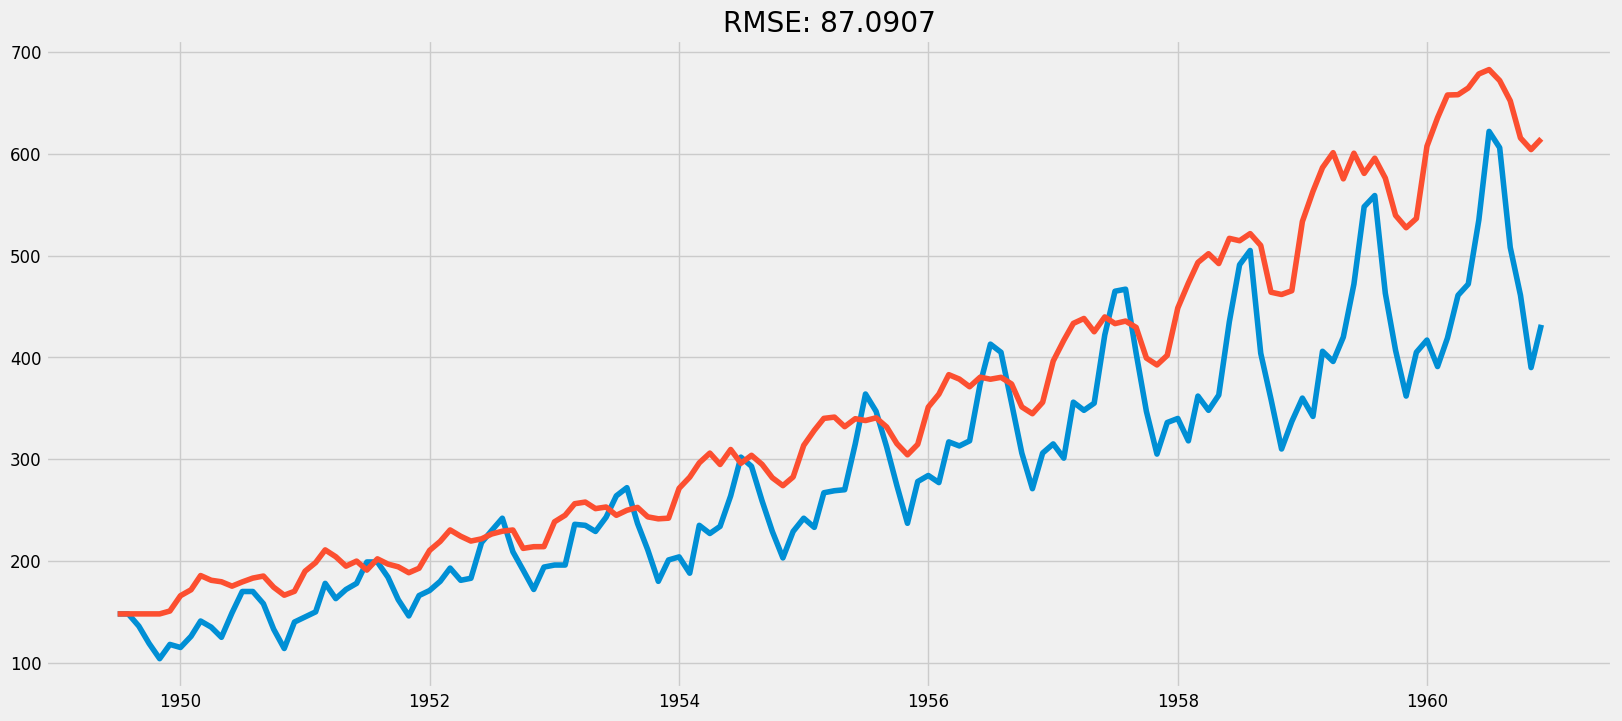

In [63]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA)
# Learner version: display plot title with RMSE rounded to four decimal places
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.passengers)**2)/len(y.passengers)))

<a name="section-3.3.1"></a>
### 3.3.1 Forecast quality scoring metrics
- __R squared__
- __Mean Absolute Error__
- __Median Absolute Error__
- __Mean Squared Error__
- __Mean Squared Logarithmic Error__
- __Mean Absolute Percentage Error__

Documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

__R squared__, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf, 1] 
- sklearn.metrics.r2_score

In [64]:
# Learner version: use documentation to find function to print r2 score
r2_score(y.passengers, predictions_ARIMA)

0.45074533610001344

__Mean Absolute Error__, it is an interpretable metric because it has the same unit of measurement as the initial series, [0, +inf)
- sklearn.metrics.mean_absolute_error

In [65]:
# Learner version: use documentation to find function to print mean absolute error
mean_absolute_error(y.passengers, predictions_ARIMA)

66.27938095662881

__Median Absolute Error__, again an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)
- sklearn.metrics.median_absolute_error

In [66]:
# Learner version: use documentation to find function to print median absolute error
median_absolute_error(y.passengers, predictions_ARIMA)

45.59734805865037

__Mean Squared Error__, most commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf)
- sklearn.metrics.mean_squared_error


In [67]:
# Learner version: use documentation to find function to print MSE
mean_squared_error(y.passengers, predictions_ARIMA)

7584.79009327279

__Mean Squared Logarithmic Error__, practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends, [0, +inf)
- sklearn.metrics.mean_squared_log_error

In [68]:
# Learner version: use documentation to find function to print MSLE
mean_squared_log_error(y.passengers, predictions_ARIMA)

0.05347553936295653

__Mean Absolute Percentage Error__, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management, [0, +inf), 
- not implemented in sklearn

In [69]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [70]:
# Learner version: call above function
mean_absolute_percentage_error(y.passengers, predictions_ARIMA)

22.930390302281012

__Function to evaluate forecast using above metrics:__

In [71]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [72]:
# Learner version: call above function
evaluate_forecast(y.passengers, predictions_ARIMA)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.450745,66.279381,45.597348,7584.790093,0.053476,22.93039,87.0907


- RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

- From an interpretation standpoint, MAE is clearly the winner. RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.

- On the other hand, one distinct advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in many mathematical calculations

<a name="section-3.4"></a>
## 3.4 Moving Average (MA)

- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


<a name="section-3.5"></a>
## 3.5 Autoregressive Moving Average (ARMA)

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


<a name="section-3.6"></a>
## 3.6 Autoregressive Integrated Moving Average (ARIMA)
In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of Differences (d):__ d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 

<br>__Observations from EDA on the time series:__
- Non stationarity implies at least one level of differencing (d) is required in ARIMA
- [The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots](https://people.duke.edu/~rnau/411arim3.htm)

[Tuning ARIMA parameters](https://machinelearningmastery.com/tune-arima-parameters-python/)


Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [73]:
ts = y.passengers - y.passengers.shift()
ts.dropna(inplace=True)

__ACF and PACF plots after differencing:__
- Confidence intervals are drawn as a cone. 
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- AR(1) process -- has ACF tailing out and PACF cutting off at lag=1
- AR(2) process -- has ACF tailing out and PACF cutting off at lag=2
- MA(1) process -- has ACF cut off at lag=1
- MA(2) process -- has ACF cut off at lag=2

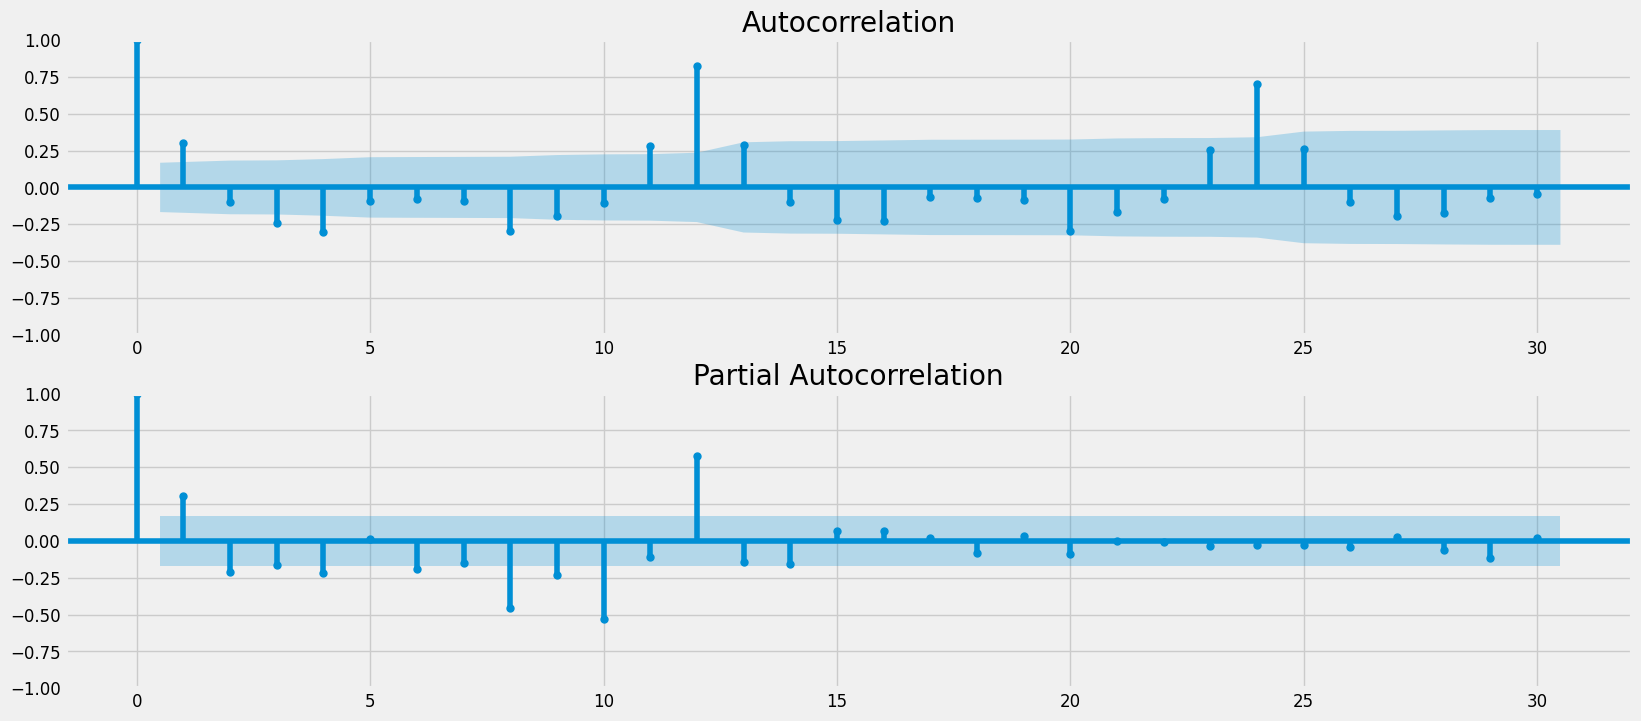

In [74]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=30)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=30)
pyplot.show()

### Interpreting ACF plots


ACF Shape	| Indicated Model |
-- | -- |
Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model |
Alternating positive and negative, decaying to zero	Autoregressive model. |  Use the partial autocorrelation plot to help identify the order. |
One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
Decay, starting after a few lags |	Mixed autoregressive and moving average (ARMA) model. | 
All zero or close to zero | Data are essentially random. |
High values at fixed intervals | Include seasonal autoregressive term. |
No decay to zero |	Series is not stationary |

<Axes: xlabel='year'>

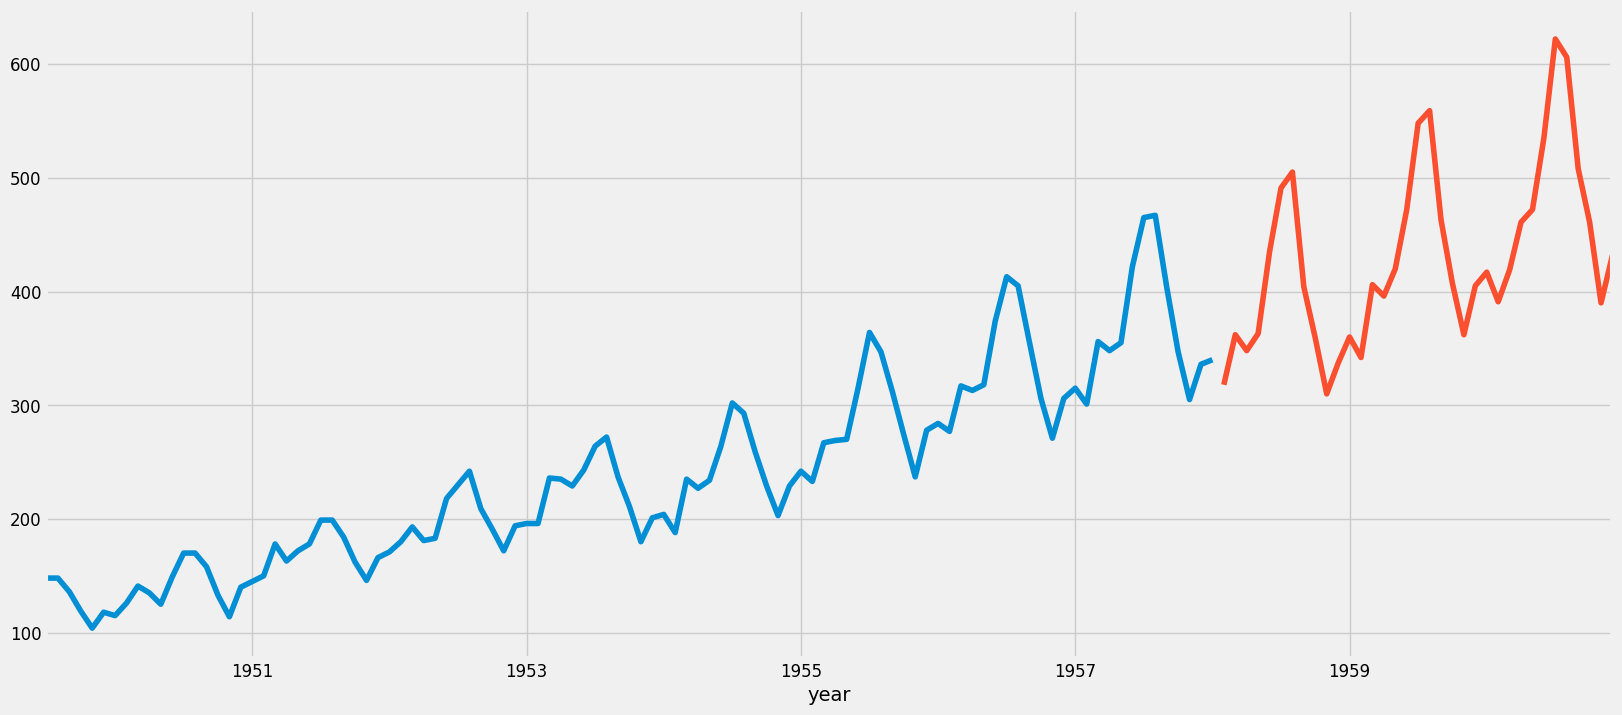

In [75]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['passengers'].plot()
valid['passengers'].plot()

In [76]:
# fit model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

In [77]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             passengers   No. Observations:                  103
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -469.903
Date:                Fri, 07 Feb 2025   AIC                            945.806
Time:                        05:34:11   BIC                            953.681
Sample:                    07-01-1949   HQIC                           948.995
                         - 01-01-1958                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5375      0.132     -4.074      0.000      -0.796      -0.279
ma.L1          0.9088      0.069     13.238      0.000       0.774       1.043
sigma2       583.1601    104.745      5.567      0.000     377.863     788.457
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 2.09
Prob(Q):                              0.72   Prob(JB):                         0.35
Heteroskedasticity (H):               4.70   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [79]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 129.12974257847102, MSE:16674.49041838219


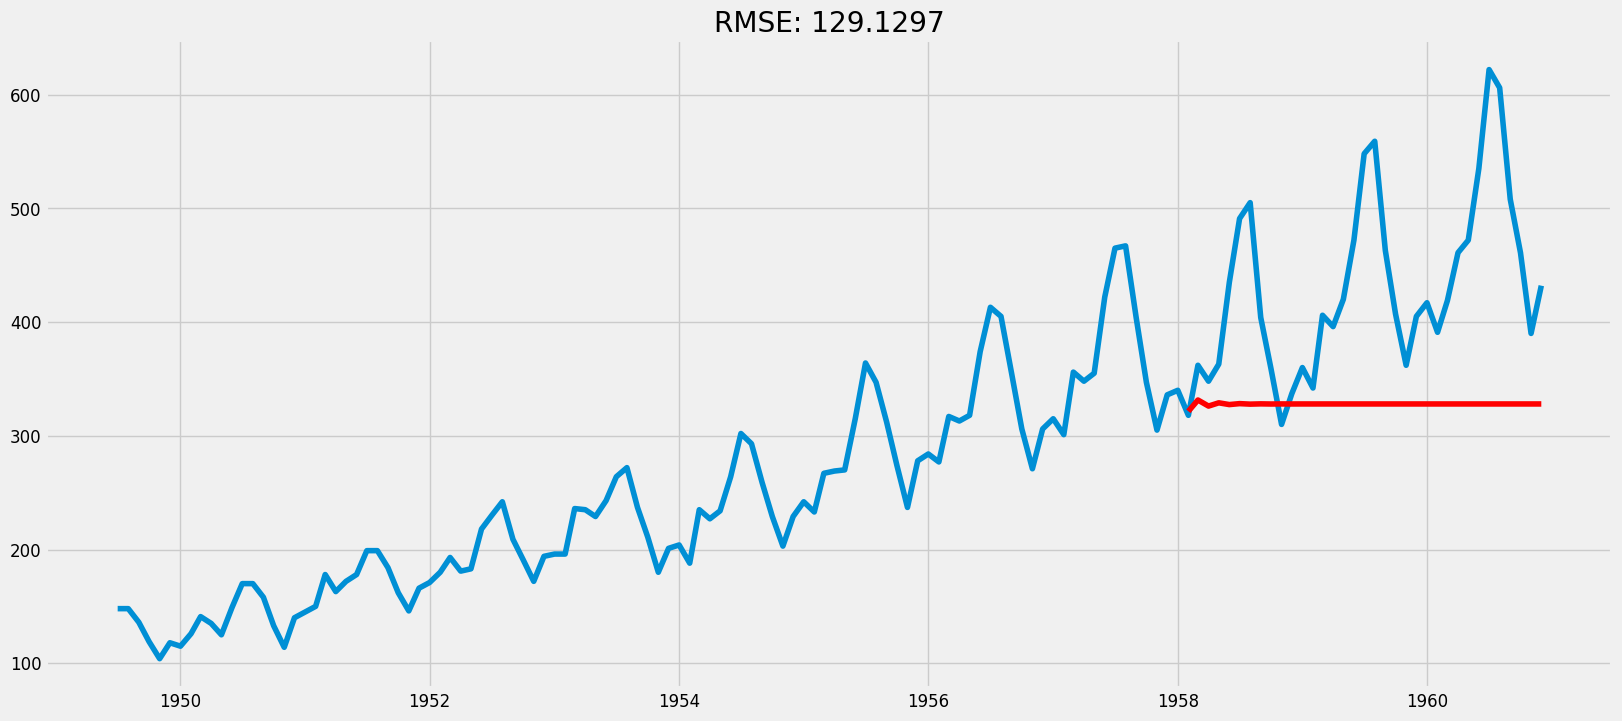

In [80]:
plt.plot(y.passengers)
plt.plot(predictions, color='red')
plt.title('RMSE: %.4f'% rmse)
plt.show()

__Fitted or predicted values:__

In [81]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

1958-02-01    321.524498
1958-03-01    331.455437
1958-04-01    326.117366
1958-05-01    328.986682
1958-06-01    327.444369
Freq: MS, Name: predicted_mean, dtype: float64


__Cumulative Sum to reverse differencing:__

In [82]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

1958-02-01     321.524498
1958-03-01     652.979936
1958-04-01     979.097302
1958-05-01    1308.083984
1958-06-01    1635.528353
Freq: MS, Name: predicted_mean, dtype: float64


__Adding 1st month value which was previously removed while differencing:__

In [83]:
predictions_ARIMA_log = pd.Series(valid.passengers.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

year
1958-02-01     639.524498
1958-03-01     970.979936
1958-04-01    1297.097302
1958-05-01    1626.083984
1958-06-01    1953.528353
dtype: float64

__Taking Exponent to reverse Log Transform:__

Text(0.5, 1.0, 'RMSE: 3560.7270')

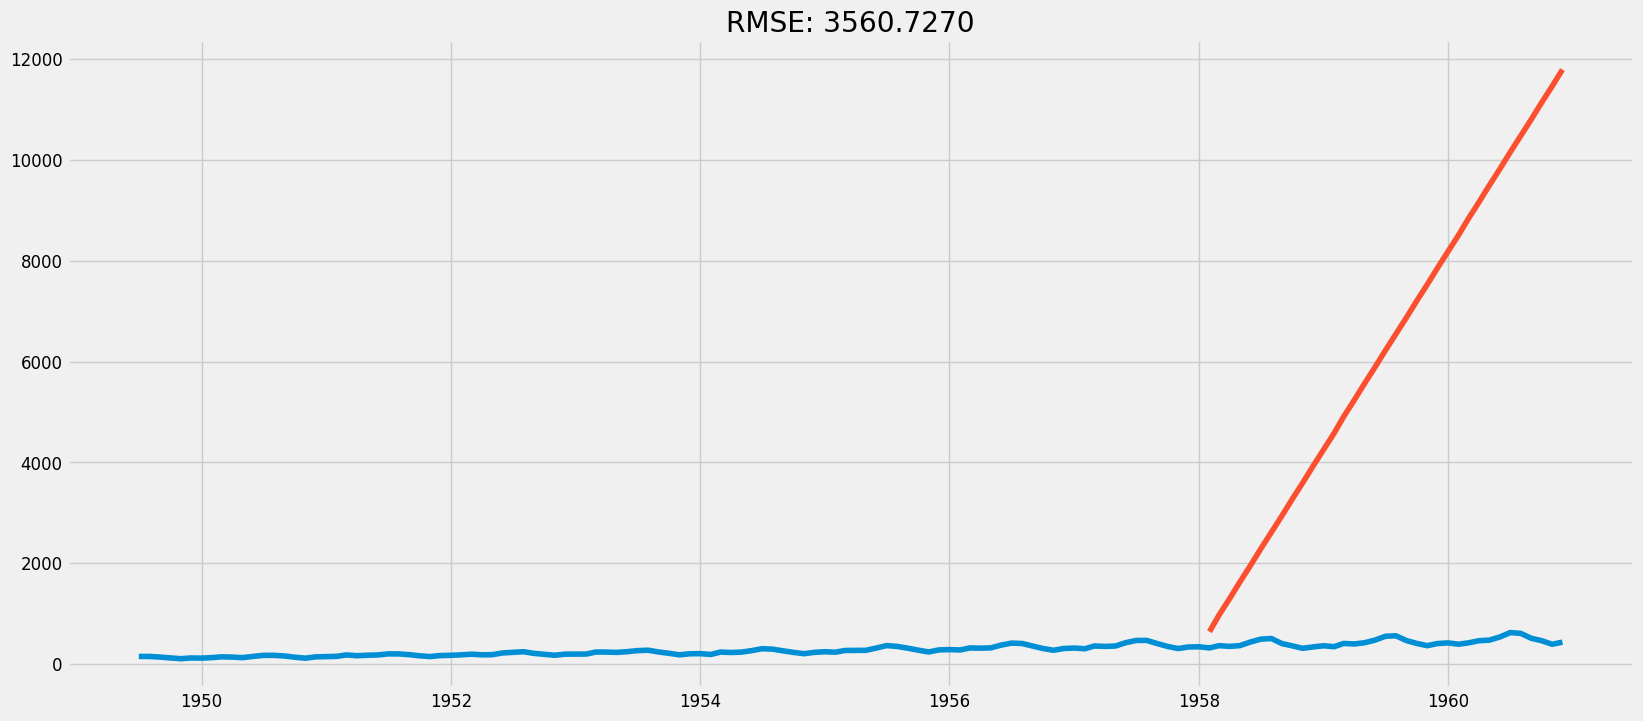

In [89]:
plt.plot(y.passengers)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

In [85]:
evaluate_forecast(y[start_index:end_index], predictions_ARIMA_log)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-7289.80125,5786.432662,5669.503254,4.420371e+07,6.551623,NaN,6648.586723


### Auto ARIMA

In [86]:
#building the model
model = pm.auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=960.245, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=954.138, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=950.096, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=958.767, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=947.431, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=948.521, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=950.589, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=945.806, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=948.377, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=952.437, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=940.710, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=949.040, Time=0.0

ARIMA(order=(4, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

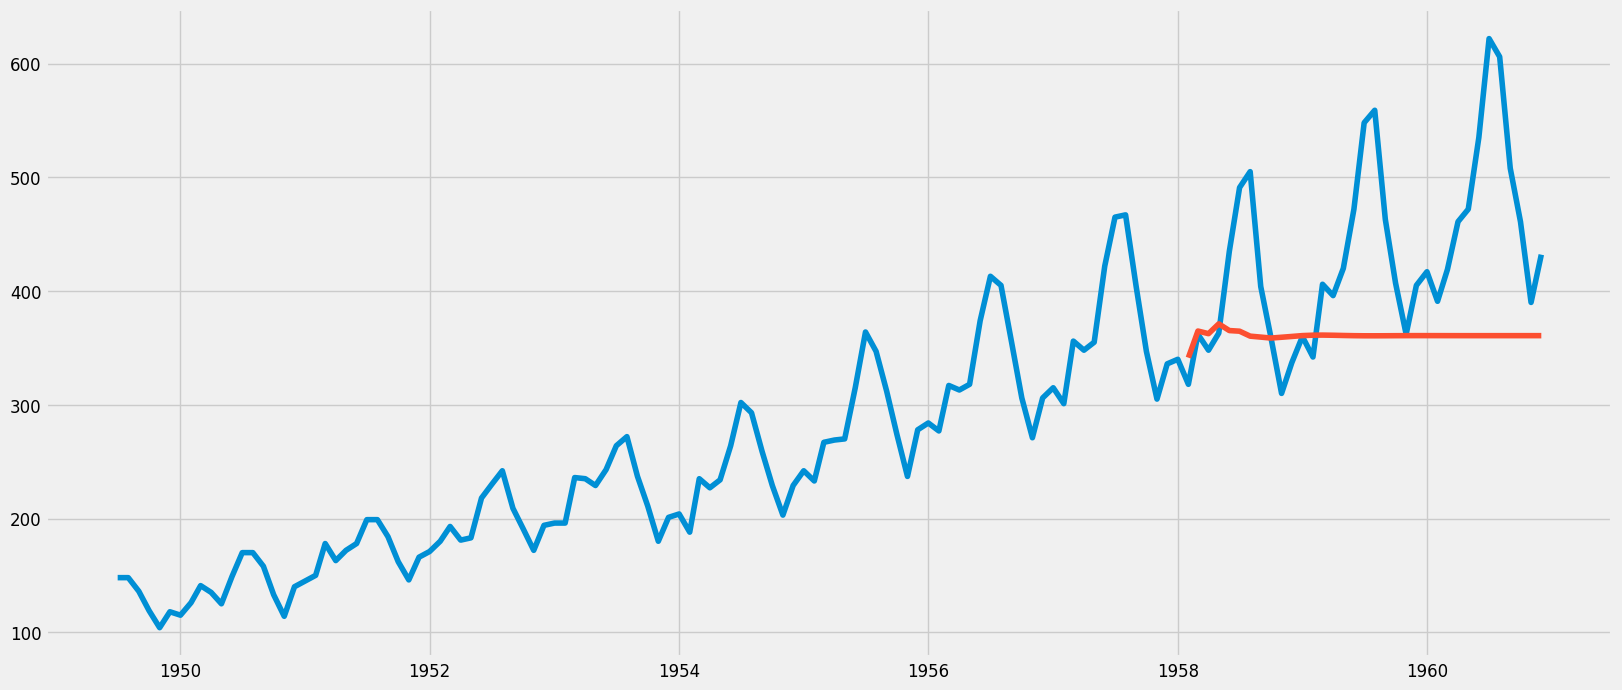

In [87]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.passengers, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [88]:
evaluate_forecast(valid, forecast)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,-0.801012,78.31278,56.183381,10919.428591,0.056199,NaN,104.49607
